<a href="https://colab.research.google.com/github/KharchenkoAnastasia/Airbus-Ship-Detection/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [33]:
!kaggle competitions download -c airbus-ship-detection

airbus-ship-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#!unzip -q train_v2.zip -d train

In [9]:
!unzip -q airbus-ship-detection -d airbus-ship-detection

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from skimage.io import imread
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib import pyplot
from keras.models import Model
from keras.layers import Input, Concatenate, Activation
from keras.layers import  UpSampling2D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
import tensorflow as tf





In [5]:
TRAIN_V2='airbus-ship-detection/train_v2/'
SEGMENTATION ='airbus-ship-detection/train_ship_segmentations_v2.csv'

print(os.listdir("airbus-ship-detection"))

train_v2 = os.listdir(TRAIN_V2)
print("Len train_v2:",len(train_v2))


train_csv = pd.read_csv(SEGMENTATION)
train_csv['withShip'] = ~train_csv['EncodedPixels'].isnull()
print(train_csv.head())


['test_v2', 'sample_submission_v2.csv', 'train_v2', 'train_ship_segmentations_v2.csv']
Len train_v2: 192556
         ImageId                                      EncodedPixels  withShip
0  00003e153.jpg                                                NaN     False
1  0001124c7.jpg                                                NaN     False
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...      True
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...      True
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...      True


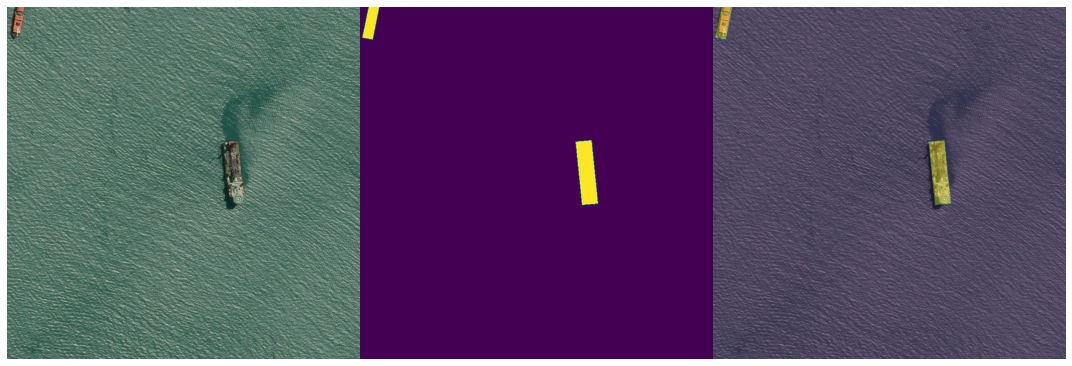

In [6]:




# =============================================================================
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction
    
# =============================================================================
# Example data
ImageId='0a2c6480e.jpg'
img = imread(TRAIN_V2 + ImageId)
img_masks = train_csv.loc[train_csv['ImageId'] == ImageId, 'EncodedPixels'].tolist()
all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += rle_decode(mask)

fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

# =============================================================================------


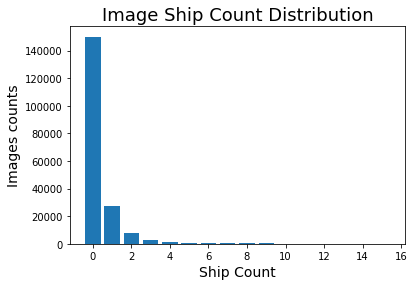

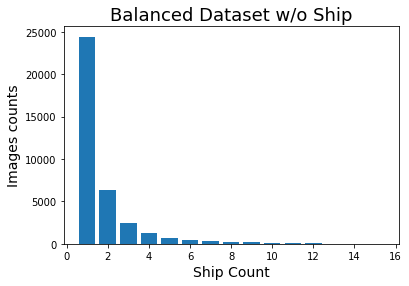

In [7]:
# Image Ship Count Distribution
figdf = train_csv.fillna(0).groupby('ImageId').sum()['withShip'].value_counts()
plt.bar(figdf.index, figdf.values)
plt.xlabel('Ship Count', fontsize=14)
plt.ylabel('Images counts', fontsize=14)
plt.title('Image Ship Count Distribution', fontsize=18)
plt.show()


# ============================================================================
# Balance the data
DROP_NO_SHIP_FRACTION = 0.8
bal_train_csv=train_csv.set_index('ImageId').drop(
    train_csv.loc[
        train_csv.isna().any(axis=1),
        'ImageId'
    ]).reset_index()

bal_train_csv=bal_train_csv.sample( frac = DROP_NO_SHIP_FRACTION , random_state=1)


# =============================================================================
#Balanced Dataset w/o Ship
figdf=bal_train_csv.groupby('ImageId').count()['withShip'].value_counts()
plt.bar(figdf.index, figdf.values)
plt.xlabel('Ship Count', fontsize=14)
plt.ylabel('Images counts', fontsize=14)
plt.title('Balanced Dataset w/o Ship', fontsize=18)
plt.show()



In [8]:
# =============================================================================
# Split train and validate data
b_train_csv, b_valid_csv = train_test_split(bal_train_csv, test_size = 0.3)
# ----------------------------------------------------------------------------------
# Keras data generator
def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)
# Hyper parameters
IMG_SCALING = (1, 1)

def keras_generator(gen_df, batch_size=4):
    all_batches = list(gen_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(TRAIN_V2, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0).astype(np.float)
                
                out_rgb, out_mask=[], []
                
# Testing the Generator
train_gen = keras_generator(bal_train_csv,6)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())



x (6, 768, 768, 3) 0.0 1.0
y (6, 768, 768, 1) 0.0 1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:


# =============================================================================
# 
# =============================================================================

# Design the Model
inp = Input(shape=(768, 768, 3))

# first block
conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)


# second block
conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)


# third block
conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)


# fourth block
conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)


# fifth block
conv_5_1 = Conv2D(512, (3, 3), padding='same')(pool_4)
conv_5_1 = Activation('relu')(conv_5_1)

conv_5_2 = Conv2D(512, (3, 3), padding='same')(conv_5_1)
conv_5_2 = Activation('relu')(conv_5_2)

pool_5 = MaxPooling2D(2)(conv_5_2)


# first decoding block
up_1 = UpSampling2D(2, interpolation='bilinear')(pool_5)
conc_1 = Concatenate()([conv_5_2, up_1])

conv_up_1_1 = Conv2D(512, (3, 3), padding='same')(conc_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(512, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)

# second decoding block
up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = Concatenate()([conv_4_2, up_2])

conv_up_2_1 = Conv2D(256, (3, 3), padding='same')(conc_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(256, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)


# third decodinc block
up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = Concatenate()([conv_3_2, up_3])

conv_up_3_1 = Conv2D(128, (3, 3), padding='same')(conc_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(128, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)


# fourth decoding block
up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_4 = Concatenate()([conv_2_2, up_4])

conv_up_4_1 = Conv2D(64, (3, 3), padding='same')(conc_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(64, (3, 3), padding='same')(conv_up_4_1)
conv_up_4_2 = Activation('relu')(conv_up_4_2)


# fifth decoding block
up_5 = UpSampling2D(2, interpolation='bilinear')(conv_up_4_2)
conc_5 = Concatenate()([conv_1_2, up_5])
conv_up_5_1 = Conv2D(32, (3, 3), padding='same')(conc_5)
conv_up_5_1 = Activation('relu')(conv_up_5_1)

conv_up_5_2 = Conv2D(1, (3, 3), padding='same')(conv_up_5_1)
result = Activation('sigmoid')(conv_up_5_2)


unet_model = Model(inputs=inp, outputs=result)

unet_model.summary()

In [10]:
from tensorflow import keras

def dice_coeff(target, pred):
  smooth = 1.0
  intersection = K.sum(target * pred, axis=[1,2,3])  
  union = K.sum(target, axis=[1,2,3]) + K.sum(pred, axis=[1,2,3])
  return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
  
def loss(target, pred):
  bce = binary_crossentropy(target, pred)
  dice_loss = 1-dice_coeff(target, pred)
  return bce-tf.math.log(1-dice_loss)

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) 
unet_model.compile(optimizer=adam, loss=loss, metrics=['binary_accuracy'])
mc = ModelCheckpoint('best_model.h5', monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)


loss_history = unet_model.fit_generator(keras_generator(b_train_csv),
                                        steps_per_epoch=20, 
                                        epochs=10, 
                                        validation_data=keras_generator(b_valid_csv),
                                        validation_steps=5)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


20/20 [==============================] - 1556s 77s/step - loss: 6.4887 - binary_accuracy: 0.9345 - val_loss: 5.2602 - val_binary_accuracy: 0.9976
Epoch 2/10
20/20 [==============================] - 1542s 77s/step - loss: 5.7998 - binary_accuracy: 0.9952 - val_loss: 7.3241 - val_binary_accuracy: 0.9948
Epoch 3/10
20/20 [==============================] - 1532s 77s/step - loss: 5.4524 - binary_accuracy: 0.9954 - val_loss: 5.2797 - val_binary_accuracy: 0.9957
Epoch 4/10
20/20 [==============================] - 1501s 75s/step - loss: 3.8238 - binary_accuracy: 0.9050 - val_loss: 2.0861 - val_binary_accuracy: 0.7591
Epoch 5/10
20/20 [==============================] - 1500s 75s/step - loss: 3.5959 - binary_accuracy: 0.7874 - val_loss: 3.4080 - val_binary_accuracy: 0.9001
Epoch 6/10
20/20 [==============================] - 1505s 76s/step - loss: 3.8255 - binary_accuracy: 0.7864 - val_loss: 5.6228 - val_binary_accuracy: 0.9964
Epoch 7/10
20/20 [==============================] - 1501s 75s/step - 

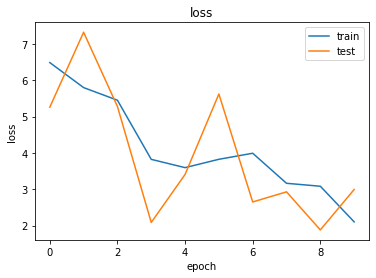

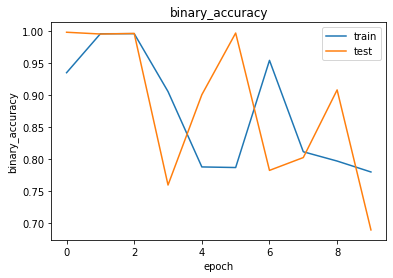

In [11]:
# Plotting Results
import matplotlib.pyplot as plt

fig = plt.figure()
pyplot.plot(loss_history.history['loss'], label='train')
pyplot.plot(loss_history.history['val_loss'], label='test')
pyplot.title('loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend()
pyplot.show()

fig = plt.figure()
pyplot.plot(loss_history.history['binary_accuracy'], label='train')
pyplot.plot(loss_history.history['val_binary_accuracy'], label='test')
pyplot.title('binary_accuracy')
pyplot.ylabel('binary_accuracy')
pyplot.xlabel('epoch')
pyplot.legend()
pyplot.show()


In [13]:
#unet_model.load_weights('best_model.h5')
unet_model.save_weights('unet_model_w.h5')
unet_model.save('unet_model.h5')


In [14]:
#ship_dir = 'airbus-ship-detection'
#test_image_dir = os.path.join(ship_dir, 'test_v2')


In [ ]:

# fig, m_axs = plt.subplots(5, 2, figsize = (10, 40))
# img_name=['00e5fb033.jpg','0da346d32.jpg','0b7359c38.jpg','0efa4a040.jpg','1b5fd69bc.jpg']
# [c_ax.axis('off') for c_ax in m_axs.flatten()]
# for (ax1, ax2), c_img_name in zip(m_axs, img_name):
#     print(c_img_name)
#     c_path = os.path.join(test_image_dir, c_img_name)
#     c_img = imread(c_path)
#     first_img = np.expand_dims(c_img, 0)/255.0
#     first_seg = unet_model.predict(first_img)
#     ax1.imshow(first_img[0])
#     ax1.set_title('Image')
#     ax2.imshow(first_seg[0, :, :, 0], vmin = 0, vmax = 1)
#     ax2.set_title('Prediction')